In [13]:
# ───────────────────────── 0. Imports ─────────────────────────
import os, re, json, pickle, warnings, time
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, whisper, soundfile as sf, librosa, librosa.display
from IPython.display import Audio, display
from sklearn.metrics import confusion_matrix

import tensorflow as tf                       # (>=2.16 pinned in reqs)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device ➜  {DEVICE}")


Using device ➜  cpu


In [14]:
# ─────────────────────── 1. Paths & metadata ───────────────────────
AUDIO_DIR = "../data/audio/custom/"           # ← your custom folder
MODEL_DIR = "../models/transformer_sentiment" # ← part-1 best model

PAT = re.compile(r"custom-([a-z]+)-[A-Z]-\d+-(.+)\.wav$", re.I)

def parse_custom(fname: str) -> dict:
    m = PAT.match(fname)
    emo, speaker = (m.group(1), m.group(2)) if m else ("unknown","unknown")
    return {"filename": fname,
            "emotion":  emo.lower(),
            "speaker":  speaker,
            "gender":   "male"}   # all recordings are male for now

audio_files = sorted(f for f in os.listdir(AUDIO_DIR)
                     if f.lower().endswith(".wav"))
meta_df = pd.DataFrame(parse_custom(f) for f in audio_files)

print(f"Loaded {len(meta_df)} custom audio files from {AUDIO_DIR}")
display(meta_df.head())

Loaded 21 custom audio files from ../data/audio/custom/


,filename,emotion,speaker,gender
0,custom-angry-A-1-Jannik.wav,angry,Jannik,male
1,custom-angry-A-1-paul.wav,angry,paul,male
2,custom-angry-A-2-Jannik.wav,angry,Jannik,male
3,custom-angry-B-1-Jannik.wav,angry,Jannik,male
4,custom-angry-B-1-paul.wav,angry,paul,male


In [15]:
# %% ─────────────────────── 2. Whisper setup ───────────────────────────
def load_whisper(size="base"):
    print(f"Loading Whisper-{size} …"); return whisper.load_model(size, device=DEVICE)

whisper_model = load_whisper("base")

def transcribe(path: Path) -> str:
    return whisper_model.transcribe(str(path),
                                    language="en",
                                    fp16=(DEVICE=="cuda"))["text"]

Loading Whisper-base …


In [16]:
# ─────────────────────── 3. Sentiment model wrapper ────────────────
class CompatibleSentimentModel:
    def __init__(self, model_dir: str):
        p = Path(model_dir)
        model_path = p/"model.keras" if (p/"model.keras").exists() else p/"model.h5"
        self.model = tf.keras.models.load_model(model_path, compile=False)
        self.word_index = pickle.load(open(p/"word_index.pkl", "rb"))
        self.label_cols = json.load(open(p/"label_cols.json"))
        self.max_len = json.load(open(p/"config.json"))["max_len"]
        thr = p/"opt_thresholds.npy"
        self.thresholds = np.load(thr) if thr.exists() else None
        print(f"Sentiment model loaded ✓  ({len(self.label_cols)} labels)")

    def _prep(self, txt: str) -> np.ndarray:
        clean = re.sub(r"<.*?>", "", txt.lower())
        clean = re.sub(r"[^a-z0-9\s]", "", clean)
        ids   = [self.word_index.get(tok, 1) for tok in clean.split()]
        ids   = (ids[:self.max_len] + [0]*self.max_len)[:self.max_len]
        return np.array([ids], dtype=np.int16)

    def predict(self, text: str, top_k=3):
        scores = self.model.predict(self._prep(text), verbose=0)[0]
        top = sorted(zip(self.label_cols, map(float, scores)),
                     key=lambda x: x[1], reverse=True)[:top_k]
        if self.thresholds is not None:
            above = [(lbl,s) for lbl,s,t in zip(self.label_cols,scores,self.thresholds) if s>=t]
        else:
            above = [(lbl,s) for lbl,s in zip(self.label_cols,scores) if s>=0.5]
        return {"top": top, "above": above, "raw": dict(zip(self.label_cols, map(float,scores)))}

sent_model = CompatibleSentimentModel(MODEL_DIR)

Sentiment model loaded ✓  (28 labels)


In [17]:
# ─────────────────────── 4. End-to-end pipeline ─────────────────────
def speech_to_sentiment(path: Path):
    txt   = transcribe(path)
    senti = sent_model.predict(txt)
    return {"file": path.name, "text": txt, "top": senti["top"]}

results = [speech_to_sentiment(Path(AUDIO_DIR)/f) for f in audio_files]

res_df = pd.DataFrame({
    "filename":        [r["file"]        for r in results],
    "transcribed_text":[r["text"]        for r in results],
    "top_emotion":     [r["top"][0][0]   for r in results],
    "top_score":       [r["top"][0][1]   for r in results],
}).merge(meta_df, on="filename")

# add empty WER (no reference sentence available for custom clips)
res_df["wer"] = np.nan

In [18]:
# ─────────────────────── 5. Accuracy & inspection ───────────────────
MAP = {"neutral":"neutral", "happy":"joy", "sad":"sadness", "angry":"anger"}
res_df["mapped_emotion"] = res_df["emotion"].map(MAP)
res_df["match"] = res_df["top_emotion"] == res_df["mapped_emotion"]
print("Top-1 emotion accuracy:", res_df["match"].mean().round(3))

# Top-3 hit
res_df["match_top3"] = res_df.apply(
    lambda r: r["mapped_emotion"] in
              [e for e,_ in sent_model.predict(r["transcribed_text"], top_k=3)["top"]],
    axis=1
)
print("Top-3 emotion accuracy:", res_df["match_top3"].mean().round(3))

# peek logits for one sample of each emotion
for emo in sorted(res_df["emotion"].unique()):
    txt = res_df.query("emotion == @emo").iloc[0]["transcribed_text"]
    raw = sent_model.predict(txt)["raw"]
    print(f"\n{emo.upper()}  →  {[f'{k}:{v:.2f}' for k,v in sorted(raw.items(), key=lambda x:-x[1])[:5]]}")

Top-1 emotion accuracy: 0.667
Top-3 emotion accuracy: 0.905

ANGRY  →  ['anger:0.80', 'annoyance:0.26', 'disgust:0.08', 'disapproval:0.04', 'disappointment:0.03']

HAPPY  →  ['joy:0.60', 'excitement:0.20', 'gratitude:0.07', 'admiration:0.05', 'love:0.04']

NEUTRAL  →  ['neutral:0.19', 'excitement:0.18', 'approval:0.10', 'curiosity:0.08', 'amusement:0.08']

SAD  →  ['sadness:0.79', 'disappointment:0.31', 'remorse:0.02', 'neutral:0.02', 'grief:0.01']


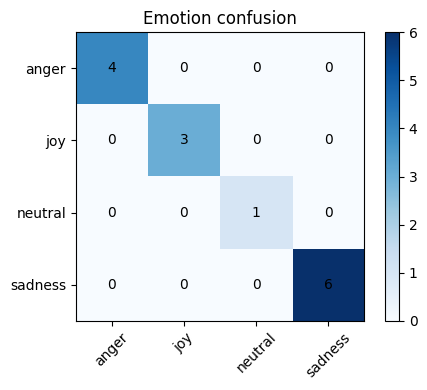

In [19]:
# ─────────────────────── 6. Confusion matrix ────────────────────────
labels = sorted(res_df["mapped_emotion"].unique())
cm = confusion_matrix(res_df["mapped_emotion"], res_df["top_emotion"], labels=labels)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
for (i,j),v in np.ndenumerate(cm):
    plt.text(j,i,v,ha="center",va="center")
plt.title("Emotion confusion"); plt.tight_layout(); plt.show()

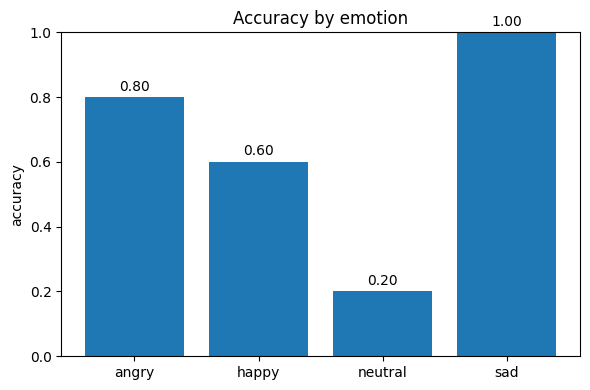

In [20]:
# ─────────────────────── 7. Breakdown plots ─────────────────────────
by_emotion = res_df.groupby("emotion").match.mean()
plt.figure(figsize=(6,4))
plt.bar(by_emotion.index, by_emotion.values)
plt.ylim(0,1); plt.ylabel("accuracy"); plt.title("Accuracy by emotion")
for i,v in enumerate(by_emotion):
    plt.text(i,v+0.02,f"{v:.2f}",ha="center")
plt.tight_layout(); plt.show()